#Transfer Learning VGG 16 and VGG 19 using Keras

Notebook is based on tutorial in link(https://www.youtube.com/watch?v=UXIrhWS0mD8)





In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/kaggle_dataset'

In [14]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [15]:
!ls

chest-xray-pneumonia  kaggle.json


In [16]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:31<00:00, 22.2MB/s]
100% 2.29G/2.29G [00:32<00:00, 76.9MB/s]


In [17]:
!mkdir chest-xray-pneumonia
!mv chest-xray-pneumonia.zip chest-xray-pneumonia

mkdir: cannot create directory ‘chest-xray-pneumonia’: File exists


In [18]:
%cd chest-xray-pneumonia/

/content/gdrive/My Drive/kaggle_dataset/chest-xray-pneumonia


In [19]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
A


#Importing libraries

In [23]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [24]:
#resizing all images
IMAGE_SIZE = [224,224]

train_path = '/content/gdrive/MyDrive/kaggle_dataset/chest-xray-pneumonia/chest_xray/train'
valid_path = '/content/gdrive/MyDrive/kaggle_dataset/chest-xray-pneumonia/chest_xray/val'

In [32]:
#Importing the Vgg 16 library. Adding a preprocessing layer before VGG. [3] is added to IMAGE_SIZE ie 224,224 inorder to convert it into a with 3 representing the RGB colors

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights = 'imagenet', include_top = False) #include top is false as imagenets top was trained to give 1000 categories whereas we only want 2 outputs, so we discard the head.

58900480/58889256 [==============================] - 1s 0us/step


In [33]:
# skip training the existing weights

for layer in vgg.layers:
  layer.trainable = False

In [34]:
#securing number of output classes based on number of folders in training folder
folders = glob('/content/gdrive/MyDrive/kaggle_dataset/chest-xray-pneumonia/chest_xray/train/*')

In [35]:
# layers
x = Flatten()(vgg.output)

In [36]:
prediction = Dense(len(folders), activation='softmax')(x)

#create a model object
model = Model(inputs=vgg.input,outputs=prediction)

In [37]:
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fd0506a4d90>>

In [38]:
#specifying cost and optimization method
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [45]:
# import Image Data Generator to import images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) #as we do not train the test set, there is no need to produce additional images in the form of augmentations as in test images

In [46]:
#target size must be the same as image size that was initailized

training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/kaggle_dataset/chest-xray-pneumonia/chest_xray/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [47]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/kaggle_dataset/chest-xray-pneumonia/chest_xray/test',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [48]:
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 1972s 12s/step - loss: 0.2562 - accuracy: 0.9116 - val_loss: 0.4765 - val_accuracy: 0.8317
Epoch 2/5
163/163 [==============================] - 118s 724ms/step - loss: 0.1155 - accuracy: 0.9565 - val_loss: 0.2761 - val_accuracy: 0.9215
Epoch 3/5
163/163 [==============================] - 115s 708ms/step - loss: 0.0987 - accuracy: 0.9638 - val_loss: 0.5259 - val_accuracy: 0.8622
Epoch 4/5
163/163 [==============================] - 116s 713ms/step - loss: 0.0878 - accuracy: 0.9672 - val_loss: 0.2570 - val_accuracy: 0.9183
Epoch 5/5
163/163 [==============================] - 116s 714ms/step - loss: 0.0699 - accuracy: 0.9716 - val_loss: 0.2328 - val_accuracy: 0.9199


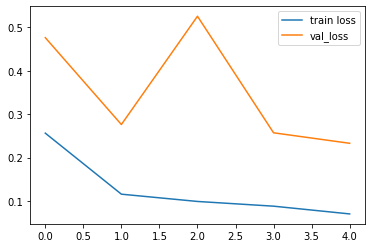

<Figure size 432x288 with 0 Axes>

In [54]:
#plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig('lossVal_loss')



In [53]:
#save the model as h5 file
import tensorflow as tf
from keras.models import load_model

model.save('model_vgg16.h5')